In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from helpers.bookmaker_selection import find_bookies_to_keep
from helpers.features import generate_bet_features, generate_match_features
from helpers.utils import data_prepare
from model import (rf_classification, rf_regression)

bookies_to_keep = find_bookies_to_keep('2018-01-01', '2019-12-25', 0.975)

bets_df = generate_bet_features(bookies_to_keep, na_ratio=0.15)
matches_df, test_match_ids = generate_match_features('2019-11-29', '2019-12-27')

final_df = data_prepare(bets_df, matches_df)

X_train = final_df[~final_df["match_id"].isin(test_match_ids)]
y_train = X_train[["result"]]

X_train = X_train.drop(["match_id", "over_under", "total_score", "result"], axis=1)
y_train = final_df[~final_df["match_id"].isin(test_match_ids)][["result"]]

X_test = final_df[final_df['match_id'].isin(test_match_ids)]
y_test = X_test[["result"]]
X_test = X_test.drop(["match_id", "over_under", "total_score", "result"], axis=1)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
import matplotlib.pyplot as plt


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers.utils import rps_metric
from sklearn.metrics import make_scorer

scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier(random_state=42, oob_score = True)

pipe = Pipeline(steps=[('rf', rf)])
param_grid = { 
    'bootstrap': [True],
    'ccp_alpha': [0],
    'n_estimators': [500],
    'max_features': ['sqrt'],
    'min_samples_leaf' : [10],
    'max_depth' : [10]
}

kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
scorer = make_scorer(rps_metric, 
                     greater_is_better=False, 
                     needs_proba=True)

search = GridSearchCV(rf, param_grid, 
                      cv=kfold, 
                      scoring = scorer, 
                      n_jobs=-1,
                      verbose=2)

In [4]:
search.fit(X_train, y_train)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   38.3s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   38.6s finished
C:\Users\erdem.banak\AppData\Local\Continuum\anaconda3\envs\erdem\lib\site-packages\sklearn\model_selection\_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=7, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              oob_score=True, random_state=42,
                                              verbose=0, warm_sta

For dimensionality reduction, we have used 2 steps. This was based on several trials between using PCA and PLS. First, we fit a random forest to the data with all the columns. Then, we are eliminating columns based on the SHAP values.

We decided to go with the SHAP values since it takes the average gain over permutations of columns. It provides us a better understanding of importance of a column.

https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

After this step, we still have around ~100 columns (cutting point was decided random; cutted from a point and checked the performance). After this point, we have used PLS. PLS is a linear transformation method, but while doing that it maximizes the covariance between response and predictors. We have tried PCA and PLS and decided to go with PLS for this step.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


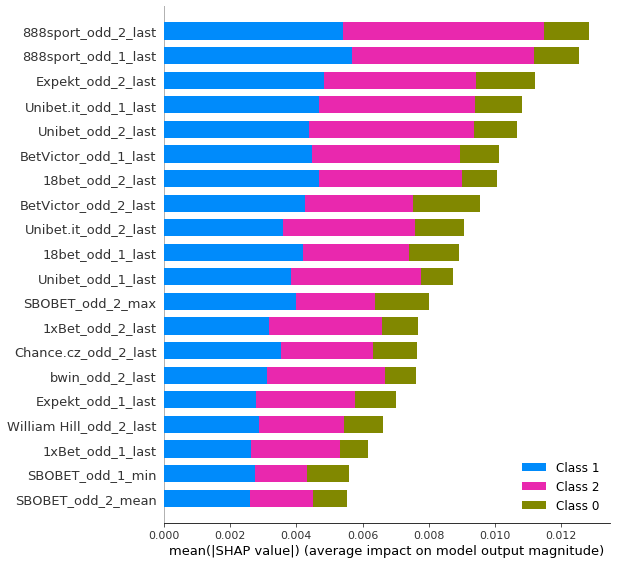

In [5]:
import shap
model = search.best_estimator_
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [7]:
vals= np.abs(shap_values).mean(0)
vals = sum(vals)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(50)

cols_to_keep = feature_importance.loc[feature_importance["feature_importance_vals"] > 1.5, "col_name"].tolist()

In [8]:
X_train_sel = X_train[[c for c in X_train.columns if c in cols_to_keep]]
X_test_sel = X_test[[c for c in X_train.columns if c in cols_to_keep]]

In [10]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=20)

y_train_pls = y_train.copy()
y_train_pls.loc[y_train_pls["result"] == 1, "Home"] = 1
y_train_pls.loc[y_train_pls["result"] != 1, "Home"] = 0
y_train_pls.loc[y_train_pls["result"] == 2, "Away"] = 1
y_train_pls.loc[y_train_pls["result"] != 2, "Away"] = 0
y_train_pls.loc[y_train_pls["result"] == 0, "Draw"] = 1
y_train_pls.loc[y_train_pls["result"] != 0, "Draw"] = 0

pls2.fit(X_train_sel, y_train_pls[["Home", "Away", "Draw"]])



X_train_pls = pls2.transform(X_train_sel)
X_test_pls = pls2.transform(X_test_sel)

We have tried different methods (LDA, SVM, ordinal regression, logistic regression, random forest, XGBOOST). XGBOOST had the highest performance with logistic regression coming second.

We also tried using ensemble methods using mlens library. We ended up over-fitting, therefore we sticked on XGBOOST. Writing an ensemble method was another option. Train error for random forest and XGBOOST are quite lower than other methods. Therefore using a linear regression on train errors ended up with overfitting.

In [32]:
rf = RandomForestClassifier(random_state=42, oob_score = True)

pipe = Pipeline(steps=[('rf', rf)])
param_grid = { 
    'bootstrap': [True],
    'ccp_alpha': [0],
    'n_estimators': [1000],
    'max_features': [None],
    'min_samples_leaf' : [20],
    'max_depth' : [8]
}

kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
scorer = make_scorer(rps_metric, 
                     greater_is_better=False, 
                     needs_proba=True)

search = GridSearchCV(rf, param_grid, 
                      cv=kfold, 
                      scoring = scorer, 
                      n_jobs=-1,
                      verbose=2)

In [195]:
search.fit(X_train_pls, y_train)

Fitting 8 folds for each of 2 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.6min finished
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=7, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              oob_score=True, random_state=42,
                                              verbose=0, warm_sta

In [197]:
rf_train = search.predict_proba(X_train_pls)

print(rps_metric(y_train, rf_train))

rf_test = search.predict_proba(X_test_pls)

print(rps_metric(y_test, rf_test))

print(search.best_score_)

0.16388441303494306
0.21415022222222227
-0.2054717788859644


In [31]:
search.best_params_
#search.best_score_

{'bootstrap': True,
 'ccp_alpha': 0,
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 20,
 'n_estimators': 1000}

In [192]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(solver = "eigen", shrinkage = "auto")

model = lda.fit(X_train, y_train)

lda_train = model.predict_proba(X_train)
print(rps_metric(y_train, lda_train))

lda_test = model.predict_proba(X_test)
print(rps_metric(y_test, lda_test))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.18584176285826462
0.21515644444444443


In [60]:
model = lda.fit(X_train_pls, y_train)

lda_res = model.predict_proba(X_train_pls)
print(rps_metric(y_train, lda_res))

lda_res = model.predict_proba(X_test_pls)
print(rps_metric(y_test[0:30], lda_res[0:30]))

model = lda.fit(X_train_PCA, y_train)

lda_res = model.predict_proba(X_train_PCA)
print(rps_metric(y_train, lda_res))

lda_res = model.predict_proba(X_test_PCA)
print(rps_metric(y_test, lda_res))


0.19819452296819787
0.22033866666666665


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


NameError: name 'X_train_PCA' is not defined

In [180]:
from sklearn import svm

svm_model = svm.SVC(decision_function_shape='ovo', probability = True)

svm_model.fit(X_train_pls, y_train)

svm_p = svm_model.predict_proba(X_train_pls)
print(rps_metric(y_train, svm_p))

svm_p = svm_model.predict_proba(X_test_pls)
print(rps_metric(y_test, svm_p))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.2051357636435022
0.2246466666666667


In [38]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from mord import LogisticAT, LogisticIT

model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced')
model_ordinal = LogisticAT(alpha= 100)



In [204]:
y_check = y_train.copy()
y_check.loc[y_check["result"] == 0, "result"] = -2
y_check.loc[y_check["result"] == 1, "result"] = 0
y_check.loc[y_check["result"] == -2, "result"] = 1

model_ordinal.fit(X_train_pls, np.ravel(y_check))
ordinal_train = model_ordinal.predict_proba(X_train_pls)
ordinal_train = [np.concatenate([m[:2][::-1], m[2:]]) for m in ordinal_train]

print(rps_metric(y_train, ordinal_train))

ordinal_test = model_ordinal.predict_proba(X_test_pls)
ordinal_test = [np.concatenate([m[:2][::-1], m[2:]]) for m in ordinal_test]

print(rps_metric(y_test, ordinal_test))

0.20070784452296822
0.21381244444444444


In [200]:
model_ordinal.fit(X_train_pls, np.ravel(y_check))

ordinal_train = model_ordinal.predict_proba(X_test_pls)
ordinal_train = [np.concatenate([m[:2][::-1], m[2:]]) for m in ordinal_train]

print(rps_metric(y_test, lda_res))

NameError: name 'y_check' is not defined

In [ ]:
print(rps_metric(y_test[37:44], lda_res[37:44]))

In [ ]:
y_test.size

In [ ]:
print(lda_res[40:50])
print(y_test[40:50])

bettor = X_test[["1xBet_odd_x_last", "1xBet_odd_1_last", "1xBet_odd_2_last"]][40:50]
rps_metric(y_test[40:50], bettor.values.tolist())

In [ ]:
bettor.values.tolist()

In [ ]:
X_test.columns[200:250]

In [227]:
model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced', max_iter = 100000)

model_multi.fit(X_train_pls, y_train)

ls_train = model_multi.predict_proba(X_train_pls)
rps_metric(y_train, ls_train)

ls_test = model_multi.predict_proba(X_test_pls)
rps_metric(y_test, ls_test)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.2095

In [46]:
from sklearn.linear_model import LogisticRegressionCV
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
from sklearn.svm import l1_min_c    


alphas = l1_min_c(X_train_pls, y_train, loss='log') * np.logspace(0, 7, 3)
model = LogisticRegressionCV(Cs=alphas, cv=kfold, random_state=42, 
                        penalty='l1', solver='saga', max_iter = 10000)

model.fit(X_train_pls,y_train)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegressionCV(Cs=array([3.30082376e-04, 1.04381213e+00, 3.30082376e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=8, random_state=7, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=10000, multi_class='auto',
                     n_jobs=None, penalty='l1', random_state=42, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

In [47]:
model.fit(X_train_pls,y_train)

lda_res = model.predict_proba(X_train_pls)
print(rps_metric(y_train, lda_res))

lda_res = model.predict_proba(X_test_pls)
print(rps_metric(y_test, lda_res))

model.fit(X_train_PCA,y_train)

lda_res = model.predict_proba(X_train_PCA)
print(rps_metric(y_train, lda_res))

lda_res = model.predict_proba(X_test_PCA)
print(rps_metric(y_test, lda_res))



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.19795337652139772
0.21271377777777778


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.19845966234786022
0.22559822222222223


In [71]:
#X_test_PCA = pca.transform(X_test)
X_test_pls = pls2.transform(X_test)

lda_res = model.predict_proba(X_test_pls)

rps_metric(y_test, lda_res)

ValueError: operands could not be broadcast together with shapes (45,476) (79,) (45,476) 

In [45]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor


import numpy as np

In [172]:
x_model = XGBClassifier(needs_proba=True)
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)

scorer = make_scorer(rps_metric, 
                     greater_is_better=False, 
                     needs_proba=True)

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softprob'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [2],
              'min_child_weight': [7],
              'silent': [1],
              'subsample': [0.6],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'seed': [1337]}

xgb = GridSearchCV(x_model, parameters, n_jobs=-1, 
                   cv=kfold, 
                   scoring= scorer,
                   verbose=2, refit=True)

In [173]:
xgb.fit(X_train_pls, y_train)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   35.2s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   35.3s finished
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=7, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     needs_proba=True, nthread=None,
                                     objec...
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.01],
                         'max_depth': [2], 'min_child_weight': [7],
                         'n_estimators': [1000], 'nthread': [4],
                         'objective': ['multi:softprob'], 'seed': [1337],
                         'silent': [1], 'subsample': [0.6]

In [174]:
lda_res = xgb.predict_proba(X_train_pls)

print(rps_metric(y_train, lda_res))


lda_res = xgb.predict_proba(X_test_pls)

print(rps_metric(y_test, lda_res))


0.17888933647428348
0.2072926666666667


In [20]:
xgb.best_params_
xgb.best_score_

-0.2043857144846316

In [107]:
xgb.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 7,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'multi:softprob',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.6}

In [235]:
xgb_train = xgb.predict_proba(X_train_pls)

xgb_test = xgb.predict_proba(X_test_pls)

print(rps_metric(y_train, xgb_train))
print(rps_metric(y_train, rf_train))


0.17888933647428348
0.16388441303494306


In [239]:
lda_res = (0.8*xgb_train + 2.5*rf_train)/3

print(rps_metric(y_train, lda_res))


0.17245025520219867


In [230]:
ordinal_test = np.asarray(ordinal_test)
ordinal_train = np.asarray(ordinal_train)
